# 1) Enegy models For LSTM AND GRU
Model by source of data: Grid5000 and A100

=== ALL POINTS ===
MAE (test): 159.0583
R² train:       0.9521
R² test:        0.9599

=== INLIERS (≤10% rel. err) ===
MAE (test): 159.0583
R² train:       0.9521
R² test:        0.9599
OLS params: duration_Activations=-75874.6467, duration_Cell_Update=44303.0453, duration_Gates=167.4528, duration_Hidden_Update=29867.7512


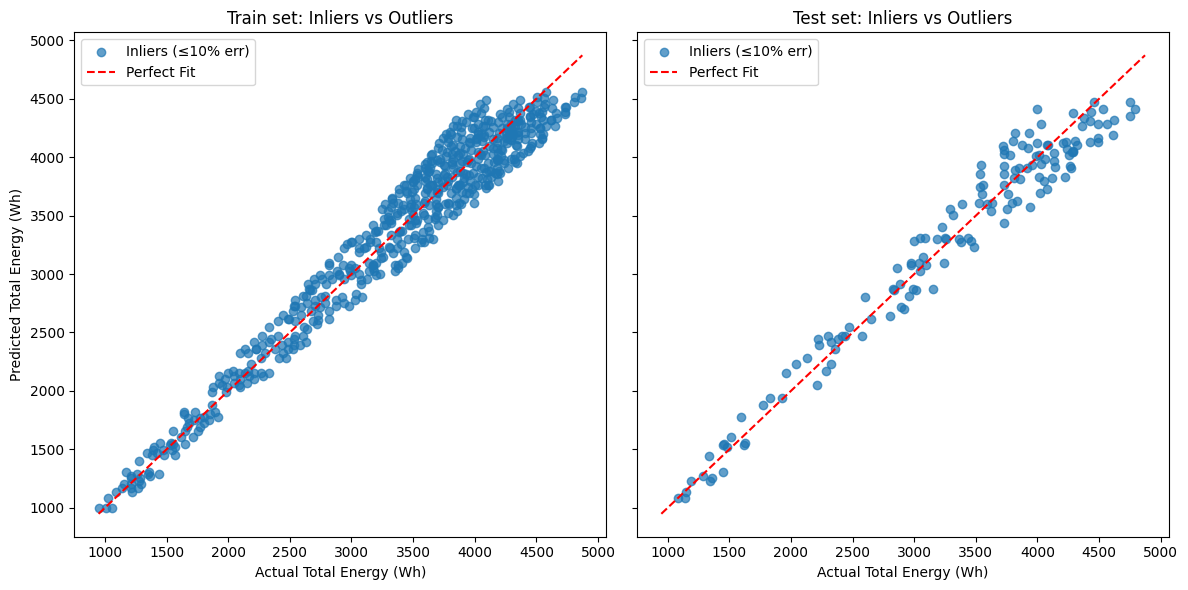

In [8]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm

df=pd.read_csv('SubsetDataForLSTM_energyModel.csv')
df['energy_consumed_kWh']=df['energy_consumed_kWh'].apply(lambda a: a* 3.6e6) ### Conver in Joules

features=['duration_Activations','duration_Cell_Update','duration_Gates','duration_Hidden_Update']


# 1) split
X_train0, X_test0, y_train, y_test = train_test_split(
    df,
    df['energy_consumed_kWh'],
    test_size=0.2,
    random_state=42
)

X_train, X_test=X_train0[features].copy(), X_test0[features].copy()
# 2) fit

model = LinearRegression().fit(X_train, y_train)

# 3) predict
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 4) compute relative errors
rel_err_train = np.abs(y_pred_train - y_train) / y_train
rel_err_test  = np.abs(y_pred_test  - y_test ) / y_test

# 5) pick your threshold (e.g. 10%)
thresh =0.5
train_mask = (rel_err_train <= thresh)
test_mask  = (rel_err_test  <= thresh)

# 6) re-compute metrics on inliers only
mae_in   = mean_absolute_error(y_test[test_mask],  y_pred_test[test_mask])
r2_train_in = r2_score(y_train[train_mask], y_pred_train[train_mask])
r2_test_in  = r2_score(y_test[test_mask],  y_pred_test[test_mask])

print("=== ALL POINTS ===")
print(f"MAE (test): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R² train:       {r2_score(y_train, y_pred_train):.4f}")
print(f"R² test:        {r2_score(y_test,  y_pred_test):.4f}")

print("\n=== INLIERS (≤10% rel. err) ===")
print(f"MAE (test): {mae_in:.4f}")
print(f"R² train:       {r2_train_in:.4f}")
print(f"R² test:        {r2_test_in:.4f}")
print("OLS params:", ", ".join(f"{features[name]}={val:.4f}"
                                   for name, val in enumerate(model.coef_)))

# --- 7) Plotting: Side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# === Training Set Plot ===
axes[0].scatter(y_train[train_mask], y_pred_train[train_mask],
                c='C0', label='Inliers (≤10% err)', alpha=0.7)
mn, mx = min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())
axes[0].plot([mn, mx], [mn, mx], 'r--', label='Perfect Fit')
axes[0].set_xlabel("Actual Total Energy (Wh)")
axes[0].set_ylabel("Predicted Total Energy (Wh)")
axes[0].set_title("Train set: Inliers vs Outliers")
axes[0].legend()

# === Test Set Plot ===
axes[1].scatter(y_test[test_mask], y_pred_test[test_mask],
                c='C0', label='Inliers (≤10% err)', alpha=0.7)

axes[1].plot([mn, mx], [mn, mx], 'r--', label='Perfect Fit')
axes[1].set_xlabel("Actual Total Energy (Wh)")
axes[1].set_title("Test set: Inliers vs Outliers")
axes[1].legend()

plt.tight_layout()
plt.show()


## Finale energy model: This is the model used in the camera ready version of the ECAI Ppaer

In [9]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

X_centered = X_train[train_mask] - X_train[train_mask].mean()

X = sm.add_constant(X_centered)

model_statsmodels = sm.OLS(y_train[train_mask], X)

results = model_statsmodels.fit()

# 3. Get the confidence intervals for the parameters
confidence_intervals = results.conf_int(alpha=0.05) # 95% confidence interval

# Print the results
print("\nStatsmodels results summary:")
print(results.summary())

print("\nConfidence Intervals for Parameters:")
print(confidence_intervals)



Statsmodels results summary:
                             OLS Regression Results                            
Dep. Variable:     energy_consumed_kWh   R-squared:                       0.952
Model:                             OLS   Adj. R-squared:                  0.952
Method:                  Least Squares   F-statistic:                     2919.
Date:                 Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                         10:27:44   Log-Likelihood:                -3976.0
No. Observations:                  592   AIC:                             7962.
Df Residuals:                      587   BIC:                             7984.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


# Example reproducible setup — replace df, pred_col, features with your own
rng = np.random.default_rng(0)

# ----- 2) Two competing specs -----
specA = make_pipeline(StandardScaler(with_mean=True, with_std=True), LinearRegression())
specB = make_pipeline(StandardScaler(with_mean=True, with_std=True), Ridge(alpha=5.0, fit_intercept=True))

# Helper: fit, extract coefficients & intercept in original feature space
def fit_and_coefs(pipeline, X, y):
    pipeline.fit(X, y)
    scaler, model = pipeline[0], pipeline[1]
    coefs = model.coef_ / scaler.scale_
    intercept = model.intercept_ - np.sum((scaler.mean_ / scaler.scale_) * model.coef_)
    return coefs, intercept, model, scaler

# ----- 3) Bootstrap coefficient CIs + test metrics -----
def bootstrap_coefs(pipeline, Xtr, ytr, Xte, yte, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(Xtr)
    coefs = []
    intercepts = []
    maes = []
    r2s = []
    
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        coefs_b, intercept_b, _, _ = fit_and_coefs(pipeline, Xtr.iloc[idx], ytr.iloc[idx])
        coefs.append(coefs_b)
        intercepts.append(intercept_b)
        
        pipeline.fit(Xtr.iloc[idx], ytr.iloc[idx])
        preds = pipeline.predict(Xte)
        maes.append(mean_absolute_error(yte, preds))
        r2s.append(r2_score(yte, preds))
    
    coefs = np.vstack(coefs)
    ci_low = np.percentile(coefs, 2.5, axis=0)
    ci_high = np.percentile(coefs, 97.5, axis=0)
    ci_width = ci_high - ci_low
    
    return {
        "ci_low": ci_low,
        "ci_high": ci_high,
        "ci_width": ci_width,
        "coef_mean": np.median(coefs, axis=0),
        "intercept_mean": np.median(intercepts),
        "mae_mean": np.median(maes),
        "r2_mean": np.median(r2s)
    }

# Run bootstraps
resA = bootstrap_coefs(specA, X_train, y_train, X_test, y_test, B=1000, seed=1)
resB = bootstrap_coefs(specB, X_train, y_train, X_test, y_test, B=1000, seed=2)

# ----- 4) Summarize -----
def summarize(name, res):
    print(f"{name}:")
    print(f"  Intercept (mean)     : {res['intercept_mean']:.4f}")
    print(f"  Mean MAE             : {res['mae_mean']:.4f}")
    print(f"  Mean R²              : {res['r2_mean']:.4f}")
    print(f"  Coefficient means    : {res['coef_mean']}")
    print(f"  CI low (2.5%)        : {res['ci_low']}")
    print(f"  CI high (97.5%)      : {res['ci_high']}")
    print(f"  CI width per feature : {res['ci_width']}")
    print(f"  Total CI width       : {res['ci_width'].sum():.4f}\n")

summarize("Spec A (OLS)", resA)
summarize("Spec B (Ridge)", resB)

# ----- 5) Choose spec -----
best_mae = min(resA["mae_mean"], resB["mae_mean"])
threshold = 1.01 * best_mae

candidates = []
for name, res in [("A", resA), ("B", resB)]:
    if res["mae_mean"] <= threshold:
        candidates.append((name, res["ci_width"].sum()))

chosen = sorted(candidates, key=lambda t: t[1])[0][0]
print(f"Chosen spec: {chosen} (smallest total CI width within 1% of best MAE)")


Spec A (OLS):
  Intercept (mean)     : 23431.4749
  Mean MAE             : 159.6186
  Mean R²              : 0.9596
  Coefficient means    : [-75906.73564315  44325.05573842    167.9107133   29955.12545308]
  CI low (2.5%)        : [-87373.55681804  38422.24136628    149.07638047  24911.457017  ]
  CI high (97.5%)      : [-65036.3943532   50518.61629995    185.56972988  35166.65482335]
  CI width per feature : [22337.16246484 12096.37493367    36.49334941 10255.19780634]
  Total CI width       : 44725.2286

Spec B (Ridge):
  Intercept (mean)     : -3395.5067
  Mean MAE             : 180.5453
  Mean R²              : 0.9479
  Coefficient means    : [394.7962046  372.46535386 163.08792606 522.48625203]
  CI low (2.5%)        : [375.55325354 346.11282098 144.5195906  481.06325151]
  CI high (97.5%)      : [413.62060553 400.26604438 179.70507824 567.18037503]
  CI width per feature : [38.06735199 54.15322341 35.18548764 86.11712352]
  Total CI width       : 213.5232

Chosen spec: A (smalle

# 2) On GPT and bert

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import pandas as pd 
import pickle
import importlib
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import seaborn as sns
from collections import Counter 

data_transf=pd.read_csv('RawDataForTransformer_energyModel.csv')
data_transf.head()

/home/mmayaki/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mmayaki/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


No Bottleneck unit testing available.


/home/mmayaki/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


,Unnamed: 0,duration,energy_joules,num_repeats,total_gpu_energy_kWh,total_cpu_energy_kWh,total_ram_energy_kWh,energy_wh_std_codecarbon,power_watt_std,time_sec_std,...,duration_QKV Projections,FLOPs_Attention Scores,HEF_Attention Scores,duration_Attention Scores,FLOPs_Attention Output,HEF_Attention Output,duration_Attention Output,FLOPs_Final Projection,HEF_Final Projection,duration_Final Projection
0,0,0.011418,0.992239,1,0.000000,7.235731e-07,2.661434e-07,0.0,0.0,0.0,...,0.000004,0.000537,1.878165,0.000004,0.000537,1.878165,0.000004,0.000268,1.119850,0.000003
1,1,0.012446,1.676083,1,0.000012,6.387458e-06,3.297791e-06,0.0,0.0,0.0,...,0.000005,0.002147,5.208760,0.000005,0.002147,5.208760,0.000005,0.000537,1.878165,0.000004
2,2,0.017370,4.110169,1,0.000033,1.176613e-05,6.102819e-06,0.0,0.0,0.0,...,0.000005,0.004832,9.292015,0.000007,0.004832,9.292015,0.000007,0.000805,2.537377,0.000004
3,3,0.023120,3.397739,1,0.000048,1.780529e-05,9.354081e-06,0.0,0.0,0.0,...,0.000006,0.008590,13.799794,0.000008,0.008590,13.799794,0.000008,0.001074,3.137870,0.000004
4,4,0.029440,3.695914,1,0.000074,2.461997e-05,1.301218e-05,0.0,0.0,0.0,...,0.000006,0.013422,18.507786,0.000009,0.013422,18.507786,0.000009,0.001342,3.697162,0.000005


In [37]:
# 'seq_length', 'batch_size', 'num_layers', 'd_model', 'num_attention_heads', 'model'
Counter(data_transf['seq_length'])

Counter({256: 25571, 512: 21461, 768: 18847, 1024: 16645, 1280: 15327})

In [ ]:
Counter(data_transf['batch_size'])

In [39]:
data_transf.columns

Index(['Unnamed: 0', 'duration', 'energy_joules', 'num_repeats',
       'total_gpu_energy_kWh', 'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'energy_wh_std_codecarbon', 'power_watt_std', 'time_sec_std', 'params',
       'seq_length', 'batch_size', 'num_layers', 'd_model',
       'num_attention_heads', 'model', 'source', 'peak', 'component',
       'total_energy_kWh', 'flops_counts', 'HEF', 'FLOPs_QKV Projections',
       'HEF_QKV Projections', 'duration_QKV Projections',
       'FLOPs_Attention Scores', 'HEF_Attention Scores',
       'duration_Attention Scores', 'FLOPs_Attention Output',
       'HEF_Attention Output', 'duration_Attention Output',
       'FLOPs_Final Projection', 'HEF_Final Projection',
       'duration_Final Projection'],
      dtype='object')

=== ALL POINTS ===
MAE (test): 22.6482
R² train:    0.5622
R² test:     0.5665

=== INLIERS (≤25% rel. err) ===
MAE (test): 7.7489
R² train:    0.9415
R² test:     0.9418
OLS params: duration_QKV Projections=-0.1025, duration_Attention Scores=0.3463, duration_Final Projection=0.4602, duration_Attention Output=0.3463
Intercept: 1.9743126862052591


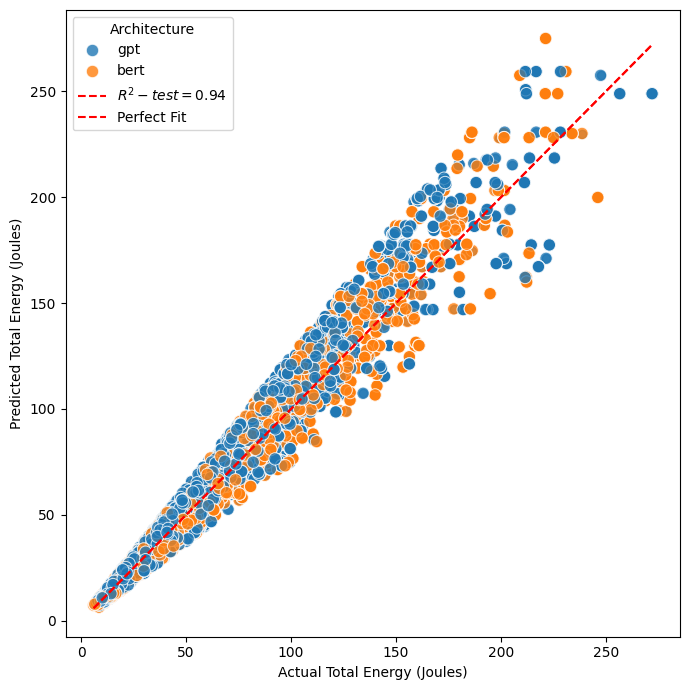

In [14]:
# Split the dataset into training and testing sets
import seaborn as sns
df=data_transf.copy()
features=['duration_QKV Projections','duration_Attention Scores','duration_Final Projection','duration_Attention Output'] 

df[features] = df[features].apply(lambda a: a * 1e6) ## convert the durations into micro seconds

pred_col='energy_joules'



# 1) split as before
X_train0, X_test0, y_train, y_test = train_test_split(
    df, df[pred_col],
    test_size=0.33,
    stratify=df[['model', 'num_layers']],
    random_state=42
)
X_train, X_test=X_train0[features].copy(), X_test0[features].copy()

# 2) fit
model = LinearRegression().fit(X_train, y_train)

# 3) predict
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 4) compute relative errors
rel_err_train = np.abs(y_pred_train - y_train) / y_train
rel_err_test  = np.abs(y_pred_test  - y_test ) / y_test

# 5) thresholds
thresh = 0.25
train_mask = (rel_err_train <= thresh)
test_mask  = (rel_err_test  <= thresh)

# 6) metrics
print("=== ALL POINTS ===")
print(f"MAE (test): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R² train:    {r2_score(y_train, y_pred_train):.4f}")
print(f"R² test:     {r2_score(y_test,  y_pred_test):.4f}")

print("\n=== INLIERS (≤25% rel. err) ===")
print(f"MAE (test): {mean_absolute_error(y_test[test_mask], y_pred_test[test_mask]):.4f}")
print(f"R² train:    {r2_score(y_train[train_mask], y_pred_train[train_mask]):.4f}")
print(f"R² test:     {r2_score(y_test[test_mask],  y_pred_test[test_mask]):.4f}")
print("OLS params:", ", ".join(f"{features[name]}={val:.4f}"
                                   for name, val in enumerate(model.coef_)))
print("Intercept:", model.intercept_)

r2_test = r2_score(y_test[test_mask],  y_pred_test[test_mask])
# 7) build a test‐DataFrame that includes num_layers
df_test = X_test.copy()
df_test['actual']       = y_test
df_test['predicted']    = y_pred_test
# retrieve num_layers by reindexing original df
df_test['model']   = df.loc[y_test.index, 'model']

# 8) plot with seaborn
plt.figure(figsize=(7,7))

plt.scatter(
    y_test[test_mask],
    y_pred_test[test_mask],
    c='C0', alpha=0.7
)
# perfect‐fit line
mn, mx = df_test[test_mask]['actual'].min(), df_test[test_mask]['actual'].max()


sns.scatterplot(
    data=df_test[test_mask],
    x="actual", y="predicted",
    hue="model",
    palette="tab10",
    alpha=0.8,
    edgecolor="w",
    s=80
)
plt.plot([mn, mx], [mn, mx], 'r--', label=f"$R^2 - test=${r2_test:.2f}")

#plt.scatter(np.exp(y_train), np.exp(y_pred_train), color="blue", alpha=0.7, label=f"$R^2=${r2_train:.2f}")
plt.plot([mn, mx], [mn, mx], 'r--', label='Perfect Fit')

plt.xlabel("Actual Total Energy (Joules)")
plt.ylabel("Predicted Total Energy (Joules)")
#plt.title("Test Set Predictions Colored by num_layers")
plt.legend(title="Architecture")
plt.tight_layout()
#plt.savefig("bert-gpt-predictions2.png")

plt.show()



In [15]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

X_tr=pd.concat([X_train0[train_mask],X_test0[test_mask]],axis=0)
y_tr=pd.concat([y_train[train_mask],y_test[test_mask]],axis=0)

X_centered = X_tr[features] - X_tr[features].mean()

X = sm.add_constant(X_centered)
model_statsmodels = sm.OLS(y_tr, X)
results = model_statsmodels.fit()

# 3. Get the confidence intervals for the parameters
confidence_intervals = results.conf_int(alpha=0.05) # 95% confidence interval

# Print the results
print("\nStatsmodels results summary:")
print(results.summary())

print("\nConfidence Intervals for Parameters:")
print(confidence_intervals)


Statsmodels results summary:
                            OLS Regression Results                            
Dep. Variable:          energy_joules   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 2.618e+05
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:40:17   Log-Likelihood:            -1.2262e+05
No. Observations:               33660   AIC:                         2.453e+05
Df Residuals:                   33656   BIC:                         2.453e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


# Example reproducible setup — replace df, pred_col, features with your own
rng = np.random.default_rng(0)

features=['duration_QKV Projections','duration_Attention Scores','duration_Final Projection','duration_Attention Output'] 

X_train0, X_test0, y_train, y_test = train_test_split(
    X_tr, y_tr,
    test_size=0.33,
    stratify=X_tr[['model', 'num_layers']],
    random_state=42
)
X_train, X_test = X_train0[features].copy(), X_test0[features].copy()

# ----- 2) Two competing specs -----
specA = make_pipeline(StandardScaler(with_mean=True, with_std=True), LinearRegression())
specB = make_pipeline(StandardScaler(with_mean=True, with_std=True), Ridge(alpha=5.0, fit_intercept=True))

# Helper: fit, extract coefficients & intercept in original feature space
def fit_and_coefs(pipeline, X, y):
    pipeline.fit(X, y)
    scaler, model = pipeline[0], pipeline[1]
    coefs = model.coef_ / scaler.scale_
    intercept = model.intercept_ - np.sum((scaler.mean_ / scaler.scale_) * model.coef_)
    return coefs, intercept, model, scaler

# ----- 3) Bootstrap coefficient CIs + test metrics -----
def bootstrap_coefs(pipeline, Xtr, ytr, Xte, yte, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(Xtr)
    coefs = []
    intercepts = []
    maes = []
    r2s = []
    
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        coefs_b, intercept_b, _, _ = fit_and_coefs(pipeline, Xtr.iloc[idx], ytr.iloc[idx])
        coefs.append(coefs_b)
        intercepts.append(intercept_b)
        
        pipeline.fit(Xtr.iloc[idx], ytr.iloc[idx])
        preds = pipeline.predict(Xte)
        maes.append(mean_absolute_error(yte, preds))
        r2s.append(r2_score(yte, preds))
    
    coefs = np.vstack(coefs)
    ci_low = np.percentile(coefs, 2.5, axis=0)
    ci_high = np.percentile(coefs, 97.5, axis=0)
    ci_width = ci_high - ci_low
    
    return {
        "ci_low": ci_low,
        "ci_high": ci_high,
        "ci_width": ci_width,
        "coef_mean": np.median(coefs, axis=0),
        "intercept_mean": np.median(intercepts),
        "mae_mean": np.median(maes),
        "r2_mean": np.median(r2s)
    }

# Run bootstraps
resA = bootstrap_coefs(specA, X_train, y_train, X_test, y_test, B=1000, seed=1)
resB = bootstrap_coefs(specB, X_train, y_train, X_test, y_test, B=1000, seed=2)

# ----- 4) Summarize -----
def summarize(name, res):
    print(f"{name}:")
    print(f"  Intercept (mean)     : {res['intercept_mean']:.4f}")
    print(f"  Mean MAE             : {res['mae_mean']:.4f}")
    print(f"  Mean R²              : {res['r2_mean']:.4f}")
    print(f"  Coefficient means    : {res['coef_mean']}")
    print(f"  CI low (2.5%)        : {res['ci_low']}")
    print(f"  CI high (97.5%)      : {res['ci_high']}")
    print(f"  CI width per feature : {res['ci_width']}")
    print(f"  Total CI width       : {res['ci_width'].sum():.4f}\n")

summarize("Spec A (OLS)", resA)
summarize("Spec B (Ridge)", resB)

# ----- 5) Choose spec -----
best_mae = min(resA["mae_mean"], resB["mae_mean"])
threshold = 1.01 * best_mae

candidates = []
for name, res in [("A", resA), ("B", resB)]:
    if res["mae_mean"] <= threshold:
        candidates.append((name, res["ci_width"].sum()))

chosen = sorted(candidates, key=lambda t: t[1])[0][0]
print(f"Chosen spec: {chosen} (smallest total CI width within 1% of best MAE)")


Spec A (OLS):
  Intercept (mean)     : 3.6265
  Mean MAE             : 6.2749
  Mean R²              : 0.9594
  Coefficient means    : [-0.13442237  0.30423775  0.55398031  0.30428488]
  CI low (2.5%)        : [-1.42601973e-01 -1.83215300e+12  5.30268659e-01 -2.21710888e+12]
  CI high (97.5%)      : [-1.26496447e-01  2.21710888e+12  5.78701623e-01  1.83215300e+12]
  CI width per feature : [1.61055256e-02 4.04926188e+12 4.84329636e-02 4.04926188e+12]
  Total CI width       : 8098523765716.1777

Spec B (Ridge):
  Intercept (mean)     : 3.8223
  Mean MAE             : 6.2824
  Mean R²              : 0.9593
  Coefficient means    : [-0.12535567  0.30486176  0.52674499  0.30486176]
  CI low (2.5%)        : [-0.13300982  0.30224356  0.50311519  0.30224356]
  CI high (97.5%)      : [-0.11785195  0.30726715  0.55047915  0.30726715]
  CI width per feature : [0.01515787 0.00502359 0.04736396 0.00502359]
  Total CI width       : 0.0726

Chosen spec: B (smallest total CI width within 1% of best MA

In [31]:
X_tr.shape

(33770, 36)